In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from sklearn.decomposition import PCA, KernelPCA

In [2]:
from hsr4hci.utils.config import load_config
from hsr4hci.utils.data import load_data
from hsr4hci.utils.fits import save_fits
from hsr4hci.utils.adi_tools import derotate_frames
from hsr4hci.utils.evaluation import compute_figures_of_merit
from hsr4hci.utils.forward_modeling import get_signal_stack

## Start the experiment

In [27]:
# Beta Pic
experiment_dir = "../experiments/default/local/"
config = load_config(os.path.join(experiment_dir, 'config.json'))

stack, parang, psf_template = load_data(config["dataset"])
psf_template = psf_template[80:-80,80:-80 ]

n_components = 50

In [36]:
# HD135344
experiment_dir = "../experiments/HD135344/"
config = load_config(os.path.join(experiment_dir, 'config.json'))
stack, parang, psf_template = load_data(config["dataset"])
psf_template = psf_template[80:-80,80:-80 ]

n_components = 15

In [16]:
# HR8799
experiment_dir = "../experiments/default/local/"
config = load_config(os.path.join(experiment_dir, 'config.json'))
config["dataset"]["file_path"] = "../../../30_data/HR8799/stacked_50.hdf"
config["dataset"]["frame_size"] = [149, 149]

stack, parang, psf_template = load_data(config["dataset"])
parang = np.concatenate([parang[:280], parang[495:]])
stack = np.concatenate([stack[:280], stack[495:]])
stack = stack[:, 30:-30, 30:-30]
n_components = 5

In [28]:
stack -= np.median(stack, axis=0)
print(stack.shape)
print(psf_template.shape)

(594, 81, 81)
(25, 25)


## Add a fake planet

In [7]:
fake_signal = get_signal_stack((15, 15),
                              frame_size=(stack.shape[1],
                                          stack.shape[2]),
                              parang=parang,
                              psf_cropped=psf_template)[0]
fake_signal /= np.max(fake_signal)
fake_signal *= 20

In [8]:
stack += fake_signal

## Add grid pattern

In [18]:
pattern = np.ones((stack.shape[1], stack.shape[2]))
length = stack.shape[1]

idx = [i for i in range(stack.shape[1]) if i%10==0 or i%10==1 or i%10==2]

pattern[idx] = 0
pattern[:, idx] = 0

pattern_stack = np.array([pattern for i in range(stack.shape[0])])
pattern_stack = derotate_frames(pattern_stack, -parang)

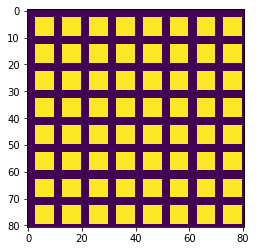

In [19]:
plt.imshow(pattern)

In [20]:
stack += pattern_stack * 10

## EM functions

In [29]:
def m_step(input_stack,
           current_planet_signal,
           prev_noise_model,
           parang,
           learning_rate,
           n_components):
    
    # 1. Build the current signal stack
    current_planet_signal_pos = deepcopy(current_planet_signal)
    current_planet_signal_pos[current_planet_signal_pos < 0] = 0  # ReLu
    signal_stack = np.array([current_planet_signal_pos for i in range(input_stack.shape[0])])
    signal_stack = derotate_frames(signal_stack, -parang)
    
    # 2. input_without planet
    input_no_planet = input_stack - signal_stack
    
    # 3. subtract the previous noise model (if no boosting this is allways zero)
    input_no_planet_noisefree = input_no_planet - prev_noise_model
    
    # 4.) Build the noise model
    tmp_pca_noise_model = PCA(n_components=n_components)
    noise_rep = tmp_pca_noise_model.fit_transform(input_no_planet_noisefree.reshape(
        input_no_planet_noisefree.shape[0], -1))
    tmp_noise_estimate = tmp_pca_noise_model.inverse_transform(noise_rep).reshape(*input_no_planet_noisefree.shape)
    noise_model = prev_noise_model + learning_rate * tmp_noise_estimate
    
    # 5.) Build residual
    residual_stack = input_no_planet - noise_model
    
    return residual_stack, noise_model

In [30]:
def e_step(residual_stack,
           current_planet_signal,
           parang,
           delta_residual=False):
    
    # 1.) Detrotate and average the resigual or delta residual
    residual_stack_rot = derotate_frames(residual_stack, parang)
    resiudal_delta_frame = np.mean(residual_stack_rot, axis=0)
    
    # 2.) a delta residual should only correct small mistakes. Its mean should be around 0.
    # Note if we don't do this there is a risk that we continously add or subtract flux all over the frame
    if delta_residual:
        resiudal_delta_frame -= np.mean(resiudal_delta_frame)
    
    # 3.) update planet signal
    current_planet_signal_pos = deepcopy(current_planet_signal)
    current_planet_signal_pos[current_planet_signal_pos < 0] = 0  # ReLu
    planet_signal = resiudal_delta_frame + current_planet_signal_pos
    
    return planet_signal

## Run the iteration

In [ ]:
planet_residuals = []

current_planet_signal = np.zeros((stack.shape[1], stack.shape[2]))
prev_noise_model = np.zeros_like(stack)
input_data = stack
learning_rate= 0.99 #0.9


tmp_comp = n_components
for boost_idx in range(5):
    
    for em_idx in tqdm(range(10)):
        if boost_idx == 0:
            tmp_lr = 1.0
        else:
            tmp_lr = learning_rate
        
        tmp_residual_stack, tmp_noise_model = m_step(input_stack=input_data,
                                                     current_planet_signal=current_planet_signal,
                                                     prev_noise_model=prev_noise_model,
                                                     parang=parang,
                                                     learning_rate=tmp_lr,
                                                     n_components=tmp_comp)
        
        tmp_planet_signal = e_step(tmp_residual_stack,
                                   current_planet_signal,
                                   parang=parang,
                                   delta_residual= not(em_idx==0))
        
        # save the result
        planet_residuals.append(deepcopy(tmp_planet_signal))
        
        # iterate
        current_planet_signal = tmp_planet_signal
    
    # boosting
    prev_noise_model = tmp_noise_model
    tmp_comp +=5  # optional: With PCA boosting is not that crucial

 20%|██        | 2/10 [00:03<00:14,  1.86s/it]

In [26]:
save_fits(planet_residuals, "/Users/markusbonse/Desktop/residuals_beta_pic_emb.fits")

In [40]:
save_fits(residuals, "/Users/markusbonse/Desktop/residuals_HD135344_15pcnm.fits")
#save_fits(delta_residuals, "/Users/markusbonse/Desktop/residuals_HD135344_delta.fits")

In [27]:
save_fits(residuals, "/Users/markusbonse/Desktop/residuals_hr8799.fits")
save_fits(delta_residuals, "/Users/markusbonse/Desktop/residuals_hr8799_delta.fits")

In [28]:
save_fits(residuals, "/Users/markusbonse/Desktop/residuals_beta_pic_grid.fits")